## WÜRTH ITALIA – Capstone Projects: Product Recommendation Project 2
### Name: Gyeongwon Song

### Importing Libraries and Reading Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from libreco.data import random_split, DatasetPure
from libreco.algorithms import NCF
from libreco.evaluation import evaluate

warnings.filterwarnings('ignore')

df = pd.read_csv('products_recommendation_dataset.txt', sep=',')

df.columns = df.columns.str.strip()

Instructions for updating:
non-resource variables are not supported in the long term


### Handle Missing Values

In [2]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values (if applicable)
df = df.dropna()

Id                         0
customerid                 0
level5id                   0
dat_action           6379695
actions_type               0
actions_count              0
att_marketsegment          0
att_saleschannel           0
att_sector                 0
level4id                   0
level3id                   0
level2id                   0
level1id                   0
dtype: int64


In [3]:
df['actions_type'].value_counts()

purchase                  207701
ecommerceAbandonedCart     79809
search                     67216
action                     50611
download                    1338
Name: actions_type, dtype: int64

### Feature Engineering

In [4]:
df = df[df['actions_type'] != 'ecommerceAbandonedCart']

In [5]:
# Convert dat_action to datetime
df['dat_action'] = pd.to_datetime(df['dat_action'])

# Convert categorical columns to category type
df['actions_type'] = df['actions_type'].astype('category')
df['att_sector'] = df['att_sector'].astype('category')

# Remove duplicates
df = df.drop_duplicates()

# Add a new feature for the month of the action
df['action_month'] = df['dat_action'].dt.month

# Aggregate actions by customer, level5id, and day
daily_actions = df.groupby(['customerid', 'level5id', 'dat_action']).agg({'actions_count': 'sum'}).reset_index()

# Sort data by dat_action to maintain chronological order
daily_actions = daily_actions.sort_values(by='dat_action')

# Compute the split point
split_point = int(0.8 * len(daily_actions))

# Split the data
past_data = daily_actions.iloc[:split_point]
next_data = daily_actions.iloc[split_point:]

In [6]:
past_data['dat_action'].max()

Timestamp('2023-09-13 00:00:00')

In [7]:
next_data['dat_action'].min()

Timestamp('2023-09-13 00:00:00')

## User-Based Collaborative Filtering
### 1. Create User-Item Interaction Matrix

In [8]:
# Create user-item interaction matrix
user_item_matrix = past_data.pivot_table(index='customerid', columns='level5id', values='actions_count', aggfunc='sum', fill_value=0)

In [9]:
user_item_matrix.head()

level5id,46228,501010204,501010206,501090140,503010409,503010517,503010518,503011304,503011305,503011306,...,50011201539,60150111220,60150111223,60150111224,75010308133,75010309204,75010309205,75040402090,75090101117,75090101166
customerid,,,,,,,,,,,,,,,,,,,,,
11448266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
30874266,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40422266,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
45713266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50597266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
user_item_matrix.shape

(606, 945)

### 2. Compute Similarities between Users

In [11]:
# Compute user similarities
user_similarities = cosine_similarity(user_item_matrix)
user_similarities_df = pd.DataFrame(user_similarities, index=user_item_matrix.index, columns=user_item_matrix.index)

### 3. Recommend Products

In [12]:
def recommend_products(user_id, user_item_matrix, user_similarities_df, top_n=50):
    similar_users = user_similarities_df[user_id].sort_values(ascending=False).index[1:top_n+1]
    similar_users_items = user_item_matrix.loc[similar_users].sum(axis=0)
    user_items = user_item_matrix.loc[user_id]
    recommendations = similar_users_items[user_items == 0].sort_values(ascending=False)
    return recommendations.head(top_n).index.tolist()

# Example usage
user_id = 2358331266
recommended_products = recommend_products(user_id, user_item_matrix, user_similarities_df)
print(f"Recommended products for user {user_id}: {recommended_products}")

Recommended products for user 2358331266: [3511110847, 3514081501, 3007030203, 7501030801, 2002130115, 504090414, 504020101, 7002011301, 3514080404, 3008060303, 2004020201, 2001030401, 3006110707, 504070107, 6013040716, 6501080204, 7501030823, 6501140402, 504020201, 3511140108, 6012030901, 5503020502, 7506020114, 6010010812, 3005111504, 6005030602, 3007020206, 6503090209, 6102020704, 3005071010, 3007010114, 504030131, 6005030201, 7509020211, 2016120902, 6102050301, 6013011102, 3006110704, 2016120911, 6005020501, 6013040710, 6010040106, 7001050101, 3513010527, 6012080502, 504090737, 7501050710, 6501140503, 6019152013, 6013010805]


In [13]:
# Filter the dataset for the specific customer ID
customer_data = next_data[next_data['customerid'] == 2358331266]

# Aggregate actions_count by level5id
aggregated_data = customer_data.groupby('level5id')['actions_count'].sum()

# Sort by aggregated actions_count in descending order and get the top 5
top_50_items = aggregated_data.sort_values(ascending=False).head(50)

In [14]:
top_50_items.index

Int64Index([ 504090216, 2002340105, 3008050108, 2002340602, 5504010201,
            8002131101, 3007040502, 2001030102,  508030486, 3007070101,
            5504060201, 3004030201,  504090202,  504091621, 3008060410,
            3004030202, 2001021143, 3009050302,  504080102, 3007070103,
            2001021146, 3005030202, 7506010201, 3008050106, 5001030716,
            2003020108, 2003010258, 3005090103, 6013070101, 2001021144,
            5001030203, 2012011105, 6019050215, 3008060502, 5503010601,
            2001021147,  508030421, 2002230511,  504091616, 2001021124,
            3511080103,  504090204, 2002130115, 2002110213, 3007042603,
            5504060202, 6013010402, 6012030901,  504091659, 2002310404],
           dtype='int64', name='level5id')

## Clustering Algorithm
### User Clustering
### 1. Extract Features for Users

In [19]:
user_features = past_data.groupby('customerid').agg({
    'actions_count': 'sum',
    'dat_action': pd.Series.nunique
}).rename(columns={'actions_type': 'diversity_of_actions', 'dat_action': 'frequency_of_actions'})

### 2. Finding the optimal K value: Elbow Method

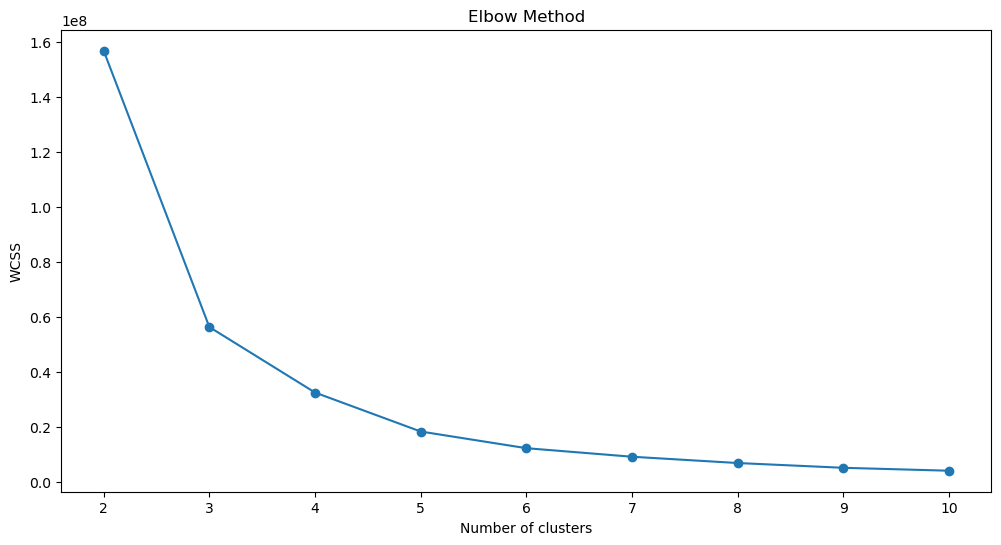

In [20]:
wcss = []
silhouette_avg_scores = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(user_features)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(user_features, kmeans.labels_)
    silhouette_avg_scores.append(silhouette_avg)

# Plot the Elbow Method
plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### 3. Apply Clustering Algorithm

In [21]:
kmeans = KMeans(n_clusters=3)
user_clusters = kmeans.fit_predict(user_features)
user_features['cluster'] = user_clusters

### 4. Recommend Based on Cluster

In [22]:
def recommend_based_on_cluster(user_id, user_features, past_data, top_n=50):
    user_cluster = user_features.loc[user_id, 'cluster']
    cluster_users = user_features[user_features['cluster'] == user_cluster].index
    cluster_items = df[df['customerid'].isin(cluster_users)]['level5id'].value_counts().head(top_n).index.tolist()
    return cluster_items

# Example usage
cluster_recommendations = recommend_based_on_cluster(user_id, user_features, past_data)
print(f"Cluster-based recommendations for user {user_id}: {cluster_recommendations}")

Cluster-based recommendations for user 2358331266: [5504010201, 2002340105, 3514081501, 3511110847, 504090216, 3512120101, 3004030202, 6014060201, 2002230511, 3514080404, 7509020201, 3511110806, 2002340602, 7501030801, 6020022301, 504091661, 2001030102, 3007070101, 3511140108, 3506010101, 6022072004, 7501050710, 3008050108, 504091621, 6102020701, 2001021143, 6020011107, 3004010404, 3512121107, 6019050211, 7501030823, 3007070103, 2002340302, 6102020703, 7505040703, 3004010406, 3008060318, 3010140815, 3005090103, 508030486, 7509020205, 3007050301, 6013011004, 3007070201, 5002130102, 6013040713, 3004060105, 3508070927, 7501030807, 5504060201]


## Machine Learning
### Neural Collaborative Filtering (NCF)
Neural Collaborative Filtering uses neural networks to model user-item interactions. This method can capture complex patterns in the data that traditional collaborative filtering methods might miss. It combines embedding layers for users and items with deep neural networks to predict user preferences.

### 1. Data Preparation

In [23]:
# Rename columns to fit LibRecommender's expectations
data = df[['customerid', 'level5id', 'actions_count', 'dat_action']]
data.columns = ['user', 'item', 'label', 'timestamp']

In [24]:
# Ensure 'timestamp' is in the correct format (if needed, convert it to UNIX timestamp)
data['timestamp'] = pd.to_datetime(data['timestamp']).astype(int) / 10**9

In [25]:
train_data, eval_data, test_data = random_split(data, multi_ratios=[0.8, 0.1, 0.1])

In [26]:
train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)

### 2. Initializaing and fitting the NCF Model

In [27]:
ncf = NCF(
    task="ranking",
    data_info=data_info,
    loss_type="cross_entropy",  # Loss type suitable for implicit feedback
    embed_size=16,  # Embedding size for user and item embeddings
    n_epochs=10,    # Number of epochs
    lr=1e-3,        # Learning rate
    batch_size=2048,  # Batch size
    num_neg=1,      # Number of negative samples (relevant for ranking)
)

# Fit the model
ncf.fit(
    train_data,
    neg_sampling=True,  # Use negative sampling for ranking
    verbose=2,
    eval_data=eval_data,
    metrics=["loss"],
)

Training start time: 2024-09-17 20:43:39
Instructions for updating:
Colocations handled automatically by placer.


2024-09-17 20:43:39,590 - WARNING - From /Users/gyeongwonsong/anaconda3/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py:883: _colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2024-09-17 20:43:39.803887: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
train: 100%|█████████████████████████████████| 256/256 [00:01<00:00, 176.10it/s]


Epoch 1 elapsed: 1.467s
	 train_loss: 0.6229


eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 155.86it/s]


	 eval log_loss: 0.6886


train: 100%|█████████████████████████████████| 256/256 [00:01<00:00, 180.49it/s]


Epoch 2 elapsed: 1.420s
	 train_loss: 0.5858


eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 239.20it/s]


	 eval log_loss: 0.5900


train: 100%|█████████████████████████████████| 256/256 [00:01<00:00, 186.34it/s]


Epoch 3 elapsed: 1.375s
	 train_loss: 0.548


eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 234.14it/s]


	 eval log_loss: 0.5159


train: 100%|█████████████████████████████████| 256/256 [00:01<00:00, 188.17it/s]


Epoch 4 elapsed: 1.361s
	 train_loss: 0.525


eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 213.44it/s]


	 eval log_loss: 0.5010


train: 100%|█████████████████████████████████| 256/256 [00:01<00:00, 167.30it/s]


Epoch 5 elapsed: 1.531s
	 train_loss: 0.5119


eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 237.75it/s]


	 eval log_loss: 0.4905


train: 100%|█████████████████████████████████| 256/256 [00:01<00:00, 149.13it/s]


Epoch 6 elapsed: 1.718s
	 train_loss: 0.5047


eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 207.58it/s]


	 eval log_loss: 0.4836


train: 100%|█████████████████████████████████| 256/256 [00:01<00:00, 198.50it/s]


Epoch 7 elapsed: 1.291s
	 train_loss: 0.4974


eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 233.86it/s]


	 eval log_loss: 0.4800


train: 100%|█████████████████████████████████| 256/256 [00:01<00:00, 194.50it/s]


Epoch 8 elapsed: 1.317s
	 train_loss: 0.4926


eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 221.75it/s]


	 eval log_loss: 0.4761


train: 100%|█████████████████████████████████| 256/256 [00:01<00:00, 195.82it/s]


Epoch 9 elapsed: 1.308s
	 train_loss: 0.4868


eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 226.37it/s]


	 eval log_loss: 0.4736


train: 100%|█████████████████████████████████| 256/256 [00:01<00:00, 198.48it/s]


Epoch 10 elapsed: 1.291s
	 train_loss: 0.4838


eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 225.92it/s]


	 eval log_loss: 0.4721


### 3. Evaluating the Model

In [28]:
evaluate(
    model=ncf,
    data=test_data,
    neg_sampling=True,  
    metrics=["loss"], 
)

eval_pointwise: 100%|████████████████████████████| 8/8 [00:00<00:00, 225.50it/s]


{'loss': 0.47038853111693213}

### 4. Predictions and Recommendations

In [29]:
# Predict preference of a user for a specific item
user_id = 2358331266
item_id = 3008060502
predicted_score = ncf.predict(user=user_id, item=item_id)
print(f"Predicted preference of user {user_id} to item {item_id}: {predicted_score}")

# Recommend top 10 items for a user
recommended_items = ncf.recommend_user(user=user_id, n_rec=10)
print(f"Top 10 recommendations for user {user_id}: {recommended_items}")

Predicted preference of user 2358331266 to item 3008060502: [0.71197736]
Top 10 recommendations for user 2358331266: {2358331266: array([6013030203, 3512120101, 3511110847, 7002011301, 3514081501,
       3514080404, 2001030401, 3006110707, 6102050301,  504020201])}
